In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from math import factorial
import math

KeyboardInterrupt: 

In [8]:
weather = pd.read_csv('weather_nyc.csv')
train_data = pd.read_feather('train_data.feather')

### Preprocess Weather

In [107]:
weather = pd.read_csv('weather_nyc.csv')

In [96]:
def time_change(x):
    x = x.split()
    x[0] = int(x[0].split(':')[0])
    if x[-1]=='PM':
        if x[0]!=12:
            x[0] = x[0]+12
    x[0] = x[0]-1
    return x[0]

In [97]:
weather['time'] = weather['time'].apply(lambda x: time_change(x))
weather['temp'] = weather['temp'].apply((lambda x: int((x-32)*5/9)))
weather.drop_duplicates(subset=['date', 'time'], keep='first', inplace=True)
weather.reset_index(inplace = True)
weather.drop(labels=['index'], axis=1, inplace = True)
weather.to_csv('weather_nyc.csv', index=False)

### Add the cluster to the original data

In [56]:
def remove_outliers(data, att):
    lb = data[att].quantile(q=0.25)-1.5*data[att].quantile()
    ub = data[att].quantile(q=0.75)+1.5*data[att].quantile()
    data = data.loc[data[att]>lb]
    data = data.loc[data[att]<ub]
    return data

def stratify_sample(data, att, n):
    lst_data = []
    unique_att = data[att].unique()
    for each_label in unique_att:
        lst_data.append(data[data[att]==each_label].sample(n=n))
    samples = lst_data[0]
    for each_data in lst_data[1:]:
        samples = pd.concat([samples, each_data])
    return samples

In [57]:
arr = pd.read_feather('clustered_data.feather')
fin_data = pd.read_feather('clean_all_data.feather')
fin_data.drop(labels='index', axis=1, inplace = True)

In [58]:
fin_data = remove_outliers(fin_data, 'fare_per_minute')
fin_data = remove_outliers(fin_data, 'clean_fare_distance')
fin_data = fin_data[fin_data['fare_per_minute']>0]
fin_data = fin_data[fin_data['clean_fare_distance']>0]
fin_data = fin_data[fin_data['misc_amount']>=0]
fin_data = remove_outliers(fin_data, 'tip_amount')
fin_data = remove_outliers(fin_data, 'misc_amount')

In [59]:
fin_data.reset_index(inplace = True)
fin_data['cluster_trip'] = arr['score_block']
train_data = fin_data[['date','PULocationID','DOLocationID', 'RatecodeID', 'hour', 'trip_distance', 
                       'time', 'fare_amount','fare_per_minute','day', 'cluster_trip', 'misc_amount']]
train_data['day_of_week']=pd.to_datetime(train_data['date']).dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [60]:
train_data.to_feather('train_data.feather')

### Predict the trip rating using real world scenario

#### Goal: Predict the trip rating to inform user whether the trip may have a high rate and misc cost or not.

Class: cluster

Attributes:
- Day of week
- Hour
- Estimated time
- Estimated distance
- PULocationID
- DOLocationID
- RatecodeID

Extra attributes:
- Temperature
- Precipitation (rain or not)

### Combine the external data first

In [61]:
weather.head()

,date,precip,temp,hour
0,2019-01-01,0.1,7,0
1,2019-01-01,0.0,8,1
2,2019-01-01,0.0,7,2
3,2019-01-01,0.0,8,3
4,2019-01-01,0.0,11,4


In [62]:
train_data.head()

,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,time,fare_amount,fare_per_minute,day,cluster_trip,misc_amount,day_of_week
0,2019-01-01,3.0,51.0,1.0,10.0,1.27,0.121389,7.00,0.961098,1.0,1,0.00,1
1,2019-01-01,3.0,61.0,5.0,10.0,21.09,0.603056,54.84,1.515615,1.0,2,0.09,1
2,2019-01-01,4.0,4.0,1.0,4.0,1.10,0.109722,6.50,0.987342,1.0,2,0.05,1
3,2019-01-01,4.0,7.0,1.0,2.0,9.61,0.471389,31.00,1.096052,1.0,2,0.01,1
4,2019-01-01,4.0,7.0,1.0,7.0,7.02,0.353056,22.00,1.038552,1.0,1,0.00,1


In [63]:
weather.columns = ['date', 'precip', 'temp', 'hour']
train_data['hour'] = train_data['hour'].astype(int)
train_data = pd.merge(train_data, weather, how='left',on=['date', 'hour'])
train_data.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
train_data['precip'].replace('in', float(0), inplace=True)
train_data['cluster_trip'] = train_data['cluster_trip'].astype(int)
train_data['precip'] = train_data['precip'].astype(float)

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15209890 entries, 0 to 16078504
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   PULocationID     float64
 2   DOLocationID     float64
 3   RatecodeID       float64
 4   hour             int64  
 5   trip_distance    float64
 6   time             float64
 7   fare_amount      float64
 8   fare_per_minute  float64
 9   day              float64
 10  cluster_trip     int64  
 11  misc_amount      float64
 12  day_of_week      int64  
 13  precip           float64
 14  temp             float64
dtypes: float64(11), int64(3), object(1)
memory usage: 1.8+ GB


In [66]:
train_data.reset_index().to_feather('train_data_fin.feather')

### Brief Visualisation (later ...)

In [34]:
sample = stratify_sample(train_data, 'cluster_trip', 500)

In [35]:
plt.figure(figsize=())

,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,time,fare_amount,fare_per_minute,day,cluster_trip,day_of_week
12317905,2019-10-04,148.0,225.0,1.0,0.0,4.200000,0.264444,15.5,0.976891,4.0,1,4
729898,2019-01-16,257.0,26.0,1.0,13.0,3.190000,0.269167,14.5,0.897833,2.0,1,2
12885882,2019-10-17,228.0,89.0,1.0,1.0,6.470000,0.223333,20.0,1.492537,3.0,1,3
3213495,2019-03-10,158.0,7.0,1.0,1.0,6.743333,0.787778,23.5,0.497179,6.0,1,6
8215013,2019-06-27,161.0,51.0,1.0,0.0,12.700000,0.385833,35.5,1.533477,3.0,1,3


<Figure size 576x432 with 0 Axes>

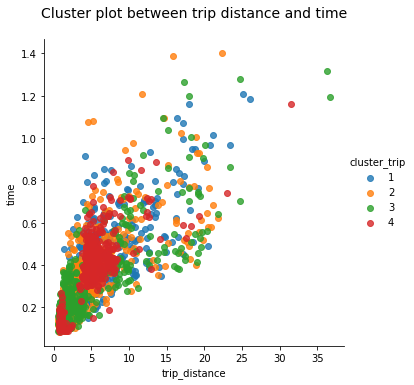

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = sns.lmplot(x="trip_distance", y="time",
                data=sample, fit_reg=False, hue='cluster_trip', legend=True)
plt.title('Cluster plot between trip distance and time\n', fontsize=14)
plt.show()

In [ ]:
# later: change the PU & DO (combined them and turn into nominal)

In [43]:
factorial(256)/(factorial(254)*factorial(2))

32640.0

In [55]:
group_plot = train_data.copy()
group_plot['count'] = 1
group_plot = group_plot.groupby(by=['PULocationID', 'date', 
                                    'cluster_trip']).sum().reset_index()[['PULocationID', 'date',
                                                                        'cluster_trip', 'count']]

In [56]:
group_plot.dropna(inplace = True)
group_plot = group_plot.groupby(by=['PULocationID', 'cluster_trip']).mean()

In [72]:
group_plot.reset_index(inplace = True)

In [66]:
group_plot.dropna(inplace = True).reset

In [76]:
index_lst = []
for i in group_plot['PULocationID'].unique():
    sliced = group_plot[group_plot['PULocationID']==i]
    index_lst.append(int(sliced[sliced['count']==max(sliced['count'])].index[0]))

In [78]:
group_plot = group_plot.loc[index_lst, :]
group_plot

,index,PULocationID,cluster_trip,count
2,2,1.0,3,1.133333
4,5,2.0,2,1.088235
6,8,3.0,1,2.751748
10,13,4.0,2,112.736986
13,16,5.0,1,1.322404
...,...,...,...,...
834,1033,261.0,2,346.038356
838,1037,262.0,2,374.860274
842,1041,263.0,2,504.728767
846,1045,264.0,2,134.391781


In [79]:
group_plot['cluster_trip'].unique()

[3, 2, 1]
Categories (3, int64): [1 < 2 < 3]

In [81]:
#grouped_do_citi['trip_count'] = np.log(grouped_do_citi['trip_count'])
# run this locally, not in VM!!!!
sf = gpd.read_file("taxi_file/taxi_zones.shp")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(pd.merge(group_plot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
# folium requires a geo JSON format for the geo_data arg, read more about it from the documentations
geoJSON = gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)
# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=group_plot,
    columns=['PULocationID', 'cluster_trip'],
    key_on='feature.properties.LocationID',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    zoomOut=False,
    legend_name='Trip frequency'
).add_to(m)


folium.LayerControl().add_to(m)



folium.Marker(
    location=[40.773565,-73.956555],
    popup='Upper East North Side: 13895 trips',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)
folium.Marker(location=[40.6413111,-73.7803278],popup="JFK NY Airport",
              tooltip='<strong>Click here to see Popup</strong>',
              icon=folium.Icon(color='purple',prefix='fa',icon='plane')).add_to(m)
folium.Marker(location=[40.6895314,-74.1766511],popup="Newark NJ Airport",
              tooltip='<strong>Click here to see Popup</strong>',
              icon=folium.Icon(color='purple',prefix='fa',icon='plane')).add_to(m)
folium.Marker(location=[40.7769271,-73.8761546],popup="LaGuardia Airport",
              tooltip='<strong>Click here to see Popup</strong>',
              icon=folium.Icon(color='purple',prefix='fa',icon='plane')).add_to(m)
#m.save('plot/last_christmas_demand.html')             
m

NameError: name 'gpd' is not defined

Does rain effect the trip distance/time?

In [98]:
rain = train_data[train_data['precip']>0]
norain = train_data[train_data['precip']==0]

In [110]:
rain.head()

,destination,index,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,time,fare_amount,fare_per_minute,day,cluster_trip,misc_amount,day_of_week,precip,temp
0,1,1691932.5,3.0,51.0,1.0,11.5,1.425,0.157361,8.25,0.876053,2.5,1.0,0.000,2.5,0.1,6.0
1,3,1679634.0,4.0,4.0,1.0,16.0,1.200,0.140278,7.50,0.891089,4.0,2.0,0.040,4.0,0.1,5.0
2,4,3707618.5,4.0,7.0,1.0,21.5,7.100,0.376667,23.00,1.040107,3.5,2.0,0.055,3.5,0.1,5.0
3,5,5125752.5,4.0,13.0,1.0,11.5,3.950,0.225139,14.25,1.053001,3.5,2.0,0.020,3.5,0.1,14.0
4,6,2718048.0,4.0,17.0,1.0,12.5,4.845,0.396667,18.75,0.837346,3.5,2.0,0.020,3.5,0.1,5.5


In [100]:
rain = rain.groupby(by=['destination']).median().reset_index()
norain = norain.groupby(by=['destination']).median().reset_index()

In [112]:
norain = norain.loc[norain['destination'].isin(rain['destination'].unique())]

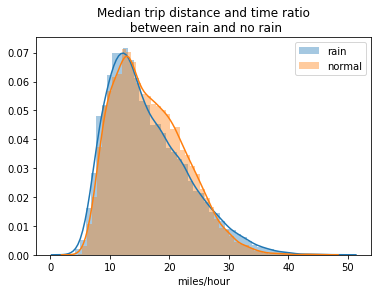

In [113]:
sns.distplot(rain['trip_distance']/rain['time'], label='rain')
sns.distplot(norain['trip_distance']/norain['time'], label='normal')
plt.legend()
plt.title('Median trip distance and time ratio\n between rain and no rain')
plt.xlabel('miles/hour')
plt.show()

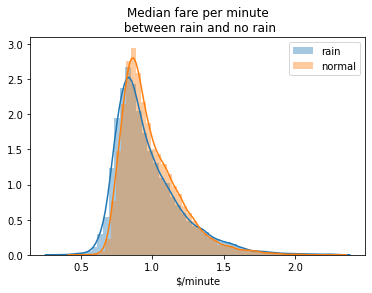

In [115]:
sns.distplot(rain['fare_per_minute'], label='rain')
sns.distplot(norain['fare_per_minute'], label='normal')
plt.legend()
plt.title('Median fare per minute\n between rain and no rain')
plt.xlabel('$/minute')
plt.show()

It seems that raining may not impact much in the distribution of the trip distance/time ratio, and the fare per minute

### Model Training

In [81]:
train_data = pd.read_feather('train_data_fin.feather')

In [84]:
train_data['destination'] = train_data['PULocationID'].astype(str)+' '+train_data['DOLocationID'].astype(str)

In [86]:
dic_dest = {}
counter = 1
for each_dest in train_data['destination'].unique():
    dic_dest[each_dest] = counter
    counter += 1

In [88]:
train_data['destination'] = train_data['destination'].apply(lambda x: dic_dest[x])
#train_data['destination'] = train_data['destination'].cat.codes

In [89]:
train_data.head()

,index,date,PULocationID,DOLocationID,RatecodeID,hour,trip_distance,time,fare_amount,fare_per_minute,day,cluster_trip,misc_amount,day_of_week,precip,temp,destination
0,0,2019-01-01,3.0,51.0,1.0,10,1.27,0.121389,7.00,0.961098,1.0,1,0.00,1,0.0,14.0,1
1,1,2019-01-01,3.0,61.0,5.0,10,21.09,0.603056,54.84,1.515615,1.0,2,0.09,1,0.0,14.0,2
2,2,2019-01-01,4.0,4.0,1.0,4,1.10,0.109722,6.50,0.987342,1.0,2,0.05,1,0.0,11.0,3
3,3,2019-01-01,4.0,7.0,1.0,2,9.61,0.471389,31.00,1.096052,1.0,2,0.01,1,0.0,7.0,4
4,4,2019-01-01,4.0,7.0,1.0,7,7.02,0.353056,22.00,1.038552,1.0,1,0.00,1,0.0,13.0,4


In [126]:
train_data.shape

(10291258, 17)

In [90]:
# split this train dataset into train, validation and test.
# cross validation may not be necessary, as the dataset is huge already
# random split will not be done for the train, as we need historical data
test_data = train_data[train_data['date']>='2019-09-01']
train_data = train_data[train_data['date']<'2019-09-01']

In [78]:
test_data['cluster_trip'].value_counts()

2    3554466
1     978565
3     384816
4        785
Name: cluster_trip, dtype: int64

Exclude the real trip distance and time, substituting it with historical trip distance and time

In [91]:
train_data
est_time_dst = train_data.groupby(by=['destination', 'hour', 'day_of_week']).median().reset_index()
est_time_dst = est_time_dst[["destination", 'hour', 'day_of_week', 'trip_distance', 'time']]

In [133]:
est_time_dst.to_feather('est_dist_time.feather')

In [132]:
est_time_dst.head()

,key_search,trip_distance,time
0,143,1.000,0.230556
1,181,2.050,0.329167
2,182,1.590,0.112222
3,191,1.405,0.132083
4,1101,1.270,0.121389


In [131]:
est_time_dst['key_search']=est_time_dst['destination'].astype('str')+est_time_dst['hour'].astype('str')+est_time_dst['day_of_week'].astype('str')
est_time_dst = est_time_dst[['key_search', 'trip_distance', 'time']]

In [117]:
est_time_dst_2 = est_time_dst.groupby(by='destination').median().reset_index()

In [120]:
est_time_dst_2 = est_time_dst_2[['destination', 'trip_distance', 'time']]
est_time_dst_2.to_feather('est_dist_time_2.feather')

In [122]:
df = pd.DataFrame([])
df['key_dest'] = list(dic_dest.keys())
df['value'] = list(dic_dest.values())

In [124]:
df.to_csv('dictionary_destination.csv')

In [134]:
test_data.drop(labels=['trip_distance', 'time', 'fare_per_minute'], axis=1, inplace = True)

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [136]:
test_data.drop(labels=['day'], axis=1, inplace = True)

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Replace all real trip distance and time with estimate 

In [150]:
merge_test = test_data.copy()
merge_test['key_search'] = merge_test['destination'].astype('str')+merge_test['hour'].astype('str')+merge_test['day_of_week'].astype('str')
merge_test = pd.merge(merge_test, est_time_dst, how='left', on='key_search')


In [151]:
nan_index = merge_test[merge_test.isnull()].index

In [152]:
iter_dest = merge_test.loc[list(nan_index)]['destination'].unique()

In [183]:
for each_dest in iter_dest:
    sliced = merge_test[merge_test['destination']==each_dest]
    sliced_index = sliced[sliced.isnull()].index

    try:
        merge_test.loc[list(sliced_index), 'trip_distance'] = est_time_dst_2[est_time_dst_2['destination']==each_dest]['trip_distance'].values[0]
    except:
        merge_test.loc[list(sliced_index), 'trip_distance'] = np.nan
    try:
        merge_test.loc[list(sliced_index), 'time'] = est_time_dst_2[est_time_dst_2['destination']==each_dest]['time'].values[0]
    except:
        merge_test.loc[list(sliced_index), 'time'] = np.nan
              

In [186]:
merge_test.dropna(inplace = True)

In [188]:
merge_test.drop(labels='key_search', axis=1, inplace = True)

In [193]:
merge_test.drop(labels='index', axis=1, inplace = True)

In [196]:
merge_test.reset_index().to_feather('X_test.feather')

In [202]:
merge_test.columns

Index(['date', 'PULocationID', 'DOLocationID', 'RatecodeID', 'hour',
       'fare_amount', 'cluster_trip', 'misc_amount', 'day_of_week', 'precip',
       'temp', 'destination', 'trip_distance', 'time'],
      dtype='object')

In [203]:
train_data.drop(labels=['fare_per_minute', 'index', 'day'], axis=1, inplace = True)

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [205]:
train_data.to_feather('X_train.feather')

# Done preprocessing for training and testing